In [1]:
# problem instance settings
state = 'LA'
deviation = 0.10  # 0.10 = 10.00%
minority = 'Black'
level = 'tract'
district_type = 'SS'

In [2]:
# read tract graph
filepath = 'C://districting-data-2020//'
filename = state + '_' + level + '.json'

from gerrychain import Graph
G = Graph.from_json( filepath + filename )

In [3]:
from util import get_census_codes
codes = get_census_codes(minority)

for i in G.nodes:
    G.nodes[i]['TOTPOP'] = G.nodes[i]['P0010001']
    G.nodes[i]['VAP'] = G.nodes[i]['P0030001']
    G.nodes[i]['MVAP'] = sum( G.nodes[i][code] for code in codes )
    
from util import number_of_districts
k = number_of_districts[state,district_type]
ideal_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes ) / k

In [4]:
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.optimization import SingleMetricOptimizer, Gingleator
from gerrychain.tree import recursive_seed_part
from functools import partial
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random

random.seed(2024)

In [5]:
chain_updaters = {
"population": updaters.Tally("TOTPOP", alias="population"),
"VAP": updaters.Tally("VAP"),
"MVAP": updaters.Tally("MVAP")
}

initial_partition = Partition.from_random_assignment(
    graph=G,
    n_parts=k,
    epsilon=deviation/2,
    pop_col="TOTPOP",
    updaters=chain_updaters
)

proposal = partial(
    proposals.recom,
    pop_col="TOTPOP",
    pop_target=ideal_population,
    epsilon=deviation/2,
    node_repeats=1
)

constraints = constraints.within_percent_of_ideal_population(initial_partition, deviation/2)

In [6]:
gingles = Gingleator(
    proposal,
    constraints,
    initial_partition,
    minority_pop_col="MVAP",
    total_pop_col="VAP",
    score_function=Gingleator.reward_partial_dist
)

In [7]:
total_steps = 10000

# Short Bursts
max_scores_sb = np.zeros(total_steps)
scores_sb = np.zeros(total_steps)
for i, part in enumerate(gingles.short_bursts(10, 1000, with_progress_bar=True)):
    max_scores_sb[i] = gingles.best_score
    scores_sb[i] = gingles.score(part)

# Simulated Annealing
max_scores_anneal = np.zeros(total_steps)
scores_anneal = np.zeros(total_steps)
for i, part in enumerate(
    gingles.simulated_annealing(
        total_steps,
        gingles.jumpcycle_beta_function(1000, 4000),
        beta_magnitude=500,
        with_progress_bar=True
    )
):
    max_scores_anneal[i] = gingles.best_score
    scores_anneal[i] = gingles.score(part)

# Tilted Runs
max_scores_tilt = np.zeros(total_steps)
scores_tilt = np.zeros(total_steps)
for i, part in enumerate(gingles.tilted_run(total_steps, 0.125, with_progress_bar=True)):
    max_scores_tilt[i] = gingles.best_score
    scores_tilt[i] = gingles.score(part)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:45<00:00, 94.92it/s]


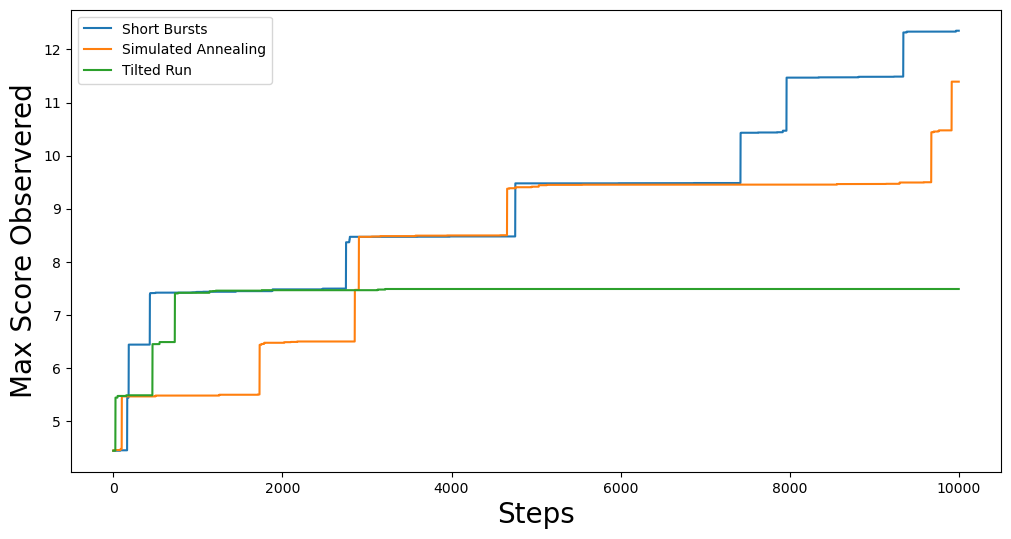

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(max_scores_sb, label="Short Bursts")
plt.plot(max_scores_anneal, label="Simulated Annealing")
plt.plot(max_scores_tilt, label="Tilted Run")
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Max Score Observered", fontsize=20)
plt.legend()
plt.show()